In [1]:
import numpy as np
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
N = 1

oms = [0.20 + 0.02 * i for i in range(11)]
ols = [0.60 + 0.02 * i for i in range(11)]

features = []
labels = []

for n in range(N):
    for om in oms:
        for ol in ols:
            filename = f"/home/jbb/Downloads/alln00/f_m{om:.2f}_L{ol:.2f}_n{n:02d}.npz"
            data = np.load(filename)

            feature = data["rho"][:-1]
            label = 1 - data["Omega_m"] - data["Omega_Lambda"]

            features.append(feature)
            labels.append(label)

print(np.array(features).shape)
print(np.array(labels).shape)


# Network



(121, 262144)
(121,)


In [4]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=1)

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)


## CNN Model for 3D Data

Building a Convolutional Neural Network to predict labels from 64×64×64 cube features.

In [9]:
x_train = np.array(x_train).reshape(-1, 64, 64, 64, 1)
x_test = np.array(x_test).reshape(-1, 64, 64, 64, 1)
y_train = np.array(y_train)
y_test = np.array(y_test)

print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")

Training data shape: (96, 64, 64, 64, 1)
Test data shape: (25, 64, 64, 64, 1)


In [70]:
from tensorflow.keras import layers, models
adam_ = keras.optimizers.Adam(learning_rate=0.0001, weight_decay=0.0)

model = models.Sequential([
    layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=(64, 64, 64, 1)),
    layers.MaxPooling3D(pool_size=(2, 2, 2)),

    layers.Conv3D(64, kernel_size=(3, 3, 3), activation='relu'),
    layers.MaxPooling3D(pool_size=(2, 2, 2)),

    layers.Conv3D(128, kernel_size=(3, 3, 3), activation='relu'),
    layers.MaxPooling3D(pool_size=(2, 2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    #layers.Dropout(0.3),
    layers.Dense(1)
])

model.compile(optimizer=adam_, loss='mse', metrics=['mae'])
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_36 (Conv3D)              │ (None, 62, 62, 62, 32) │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_36 (MaxPooling3D) │ (None, 31, 31, 31, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_37 (Conv3D)              │ (None, 29, 29, 29, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_37 (MaxPooling3D) │ (None, 14, 14, 14, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_38 (Conv3D)              │ (None, 12, 12, 12,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_38 (MaxPooling3D) │ (None, 6, 6, 6, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 27648)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 128)            │     3,539,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,824,961 (14.59 MB)

 Trainable params: 3,824,961 (14.59 MB)

 Non-trainable params: 0 (0.00 B)

In [71]:
history = model.fit(
    x_train, y_train,
    epochs=20,
    batch_size=8,
    validation_split=0.2,
    verbose=1,
    shuffle=True
)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 419ms/step - loss: 0.9498 - mae: 0.7014 - val_loss: 0.1302 - val_mae: 0.3452
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 384ms/step - loss: 0.2134 - mae: 0.3576 - val_loss: 0.0103 - val_mae: 0.0869
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 382ms/step - loss: 0.0403 - mae: 0.1534 - val_loss: 0.0071 - val_mae: 0.0704
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 414ms/step - loss: 0.0206 - mae: 0.1078 - val_loss: 0.0059 - val_mae: 0.0641
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 455ms/step - loss: 0.0155 - mae: 0.0994 - val_loss: 0.0044 - val_mae: 0.0542
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 436ms/step - loss: 0.0081 - mae: 0.0735 - val_loss: 0.0048 - val_mae: 0.0571
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 417ms/step - loss: 0.0079 - mae: 0.0702 - val_loss: 0.0039 - val_mae: 0.0506
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 429ms/step - loss: 0.0062 - mae: 0.0633 - val_loss: 0.0034 - val_mae: 0.0482
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 426ms/step - lo

In [75]:
test_loss, test_mae = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.6f}")
print(f"Test MAE: {test_mae:.6f}")

Test Loss: 0.018238
Test MAE: 0.113332


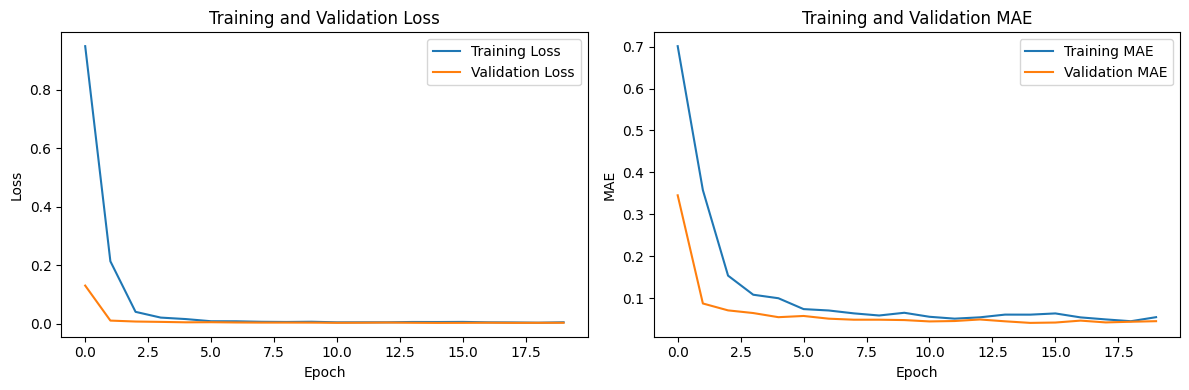

In [73]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.title('Training and Validation MAE')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


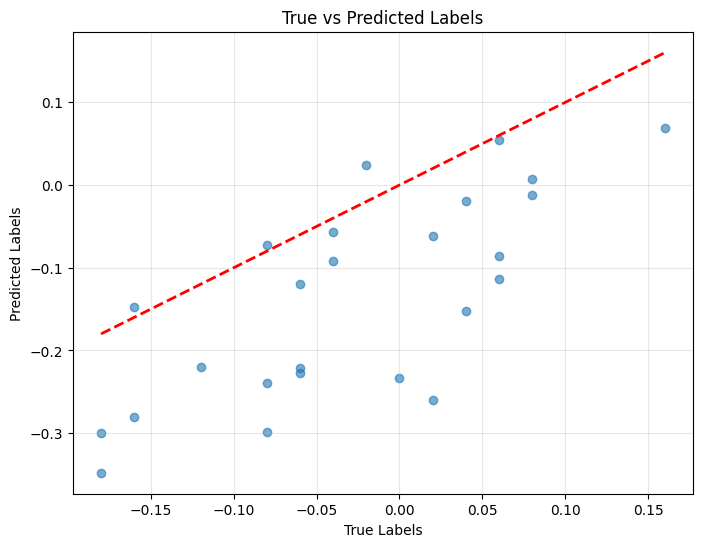

In [74]:
predictions = model.predict(x_test)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, predictions, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.title('True vs Predicted Labels')
plt.grid(True, alpha=0.3)
plt.show()
